In this notebook we perform the different classification tasks to determine which one is the best.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random_seed = 51

# Metrics for Performance Evaluation

In [2]:
class Performance_metrics():

    def __init__(self, y_actual, y_predicted, ctp=-1, ctn=0, cfp=1, cfn=10):

        self.y_actual = y_actual # df of actual class labels
        self.y_predicted = y_predicted # df of predicted class labels

        self.df_confusion = pd.crosstab(self.y_actual, self.y_predicted)
        self.tp = self.df_confusion[1][1]
        self.tn = self.df_confusion[0][0]
        self.fp = self.df_confusion[0][1]
        self.fn = self.df_confusion[1][0]

        self.ctp = ctp
        self.ctn = ctn
        self.cfp = cfp
        self.cfn = cfn
        

    def cost_matrix(self):

        """Cost of classifying instances of class j as class i.
        """

        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])
        return cost_matrix
    
    def accuracy(self):

        """Accuracy of the model.
        """
        accuracy = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)
        return accuracy
    
    def cost(self):

        """Cost of the model.
        """
        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])

        cost = (self.tp * self.ctp) + (self.tn * self.ctn) + (self.fp * self.cfp) + (self.fn * self.cfn)
        return cost
    
    def precision(self):
            
        """Precision of the model.
        """
        precision = self.tp / (self.tp + self.fp)
        return precision
    
    def recall(self):
        
        """Recall of the model.
        """
        recall = self.tp / (self.tp + self.fn)
        return recall
    
    def f_measure(self):
    
        """F-measure of the model.
        """

        f_measure = 2*self.tp / (2*self.tp + self.fp + self.fn)
        return f_measure
    

In [3]:
# Import data
df = pd.read_csv("Preprocessed data/normalized_data.csv", index_col=0)

dFeat_df = df.drop(columns = ["readmitted"])
dClass_df = df["readmitted"]

dFeat = dFeat_df.to_numpy()
dClass = dClass_df.to_numpy()

print(dFeat.shape)
print(dClass.shape)

(4837, 30)
(4837,)


# Feature Selection

## Wrapper method

In this work we are going to use Wrapper methods since they provide a balance between embedded aproaches (which depends on the algorithm) and filter approaches (which rely on statistical measures). First, we measure the variation in accuracy after removing each feature, for simplicity, we only consider random forest.

In [4]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Compute the accuracy of the model using K-fold cross-validation

# Accuracy_base = []

# for train_index, test_index in kf.split(dFeat, dClass):

#     X_train, X_test = dFeat[train_index], dFeat[test_index]
#     y_train, y_test = dClass[train_index], dClass[test_index]

#     # Create a Random Forest Classifier
#     rf = RandomForestClassifier(n_estimators=1000, random_state=42, criterion='entropy')

#     # Fit the model on the training data
#     rf.fit(X_train, y_train)

#     # Make predictions on the test data
#     y_pred = rf.predict(X_test)

#     # Calculate performance metrics
#     pm = Performance_metrics(y_test, y_pred)
#     Accuracy_base.append(pm.accuracy())

# Accuracy_base = np.mean(Accuracy_base)
# print("Accuracy with all the features: ", Accuracy_base)

# accuracy_drop = []

# for i in range(dFeat.shape[1]):

#     column = dFeat_df.columns[i]

#     dFeat1 = np.delete(dFeat, i, axis=1)
#     accuracy_list = []

#     for train_index, test_index in kf.split(dFeat1, dClass):

#         X_train, X_test = dFeat1[train_index], dFeat1[test_index]
#         y_train, y_test = dClass[train_index], dClass[test_index]

#         # Create a Random Forest Classifier
#         rf = RandomForestClassifier(n_estimators=1000, random_state=42, criterion='entropy')

#         # Fit the model on the training data
#         rf.fit(X_train, y_train)

#         # Make predictions on the test data
#         y_pred = rf.predict(X_test)

#         # Calculate performance metrics
#         pm = Performance_metrics(y_test, y_pred)
#         accuracy_list.append(pm.accuracy())

#     acc = np.mean(accuracy_list)
#     print("Accuracy without ", column, ": ", acc)

#     accuracy_drop.append(Accuracy_base - acc)

In [5]:
# accuracy_drop_df = pd.DataFrame(accuracy_drop, index=dFeat_df.columns, columns=["Accuracy drop"])
# accuracy_drop_df = accuracy_drop_df.sort_values(by="Accuracy drop", ascending=False)

# accuracy_drop_df.plot(kind='bar', legend=False, figsize=(12, 6))
# plt.ylabel('Accuracy drop')
# plt.title('Accuracy drop with feature removal')
# plt.xticks(rotation=90)
# plt.tight_layout()

## Mean decrease in impurity

Another metric in RF classifier is the MDI (Mean Decrease impurity) which counts the number of times a feature is used to a split a node weighted by the number of samples it splits. [cite web]

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

Text(0, 0.5, 'Mean decrease in impurity')

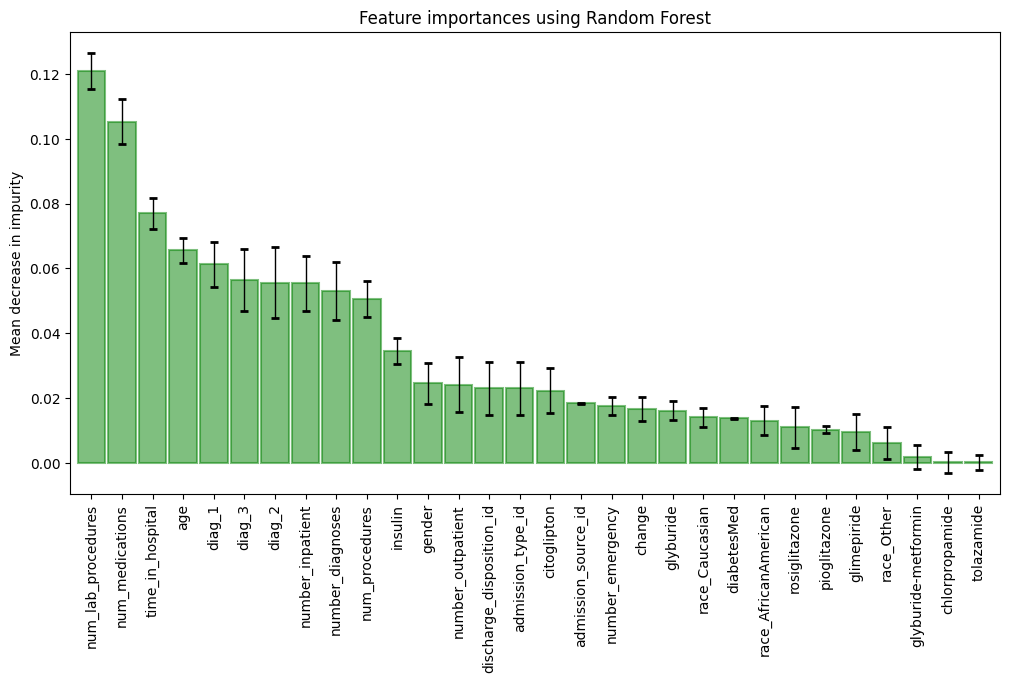

In [7]:


forest = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')
forest.fit(dFeat, dClass)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame(importances, index=dFeat_df.columns, columns=["Importance"])
forest_importances = forest_importances.sort_values(by="Importance", ascending=False)

forest_importances.plot.bar(yerr=std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
plt.title("Feature importances using Random Forest") 
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in impurity")

## Feature Permutation

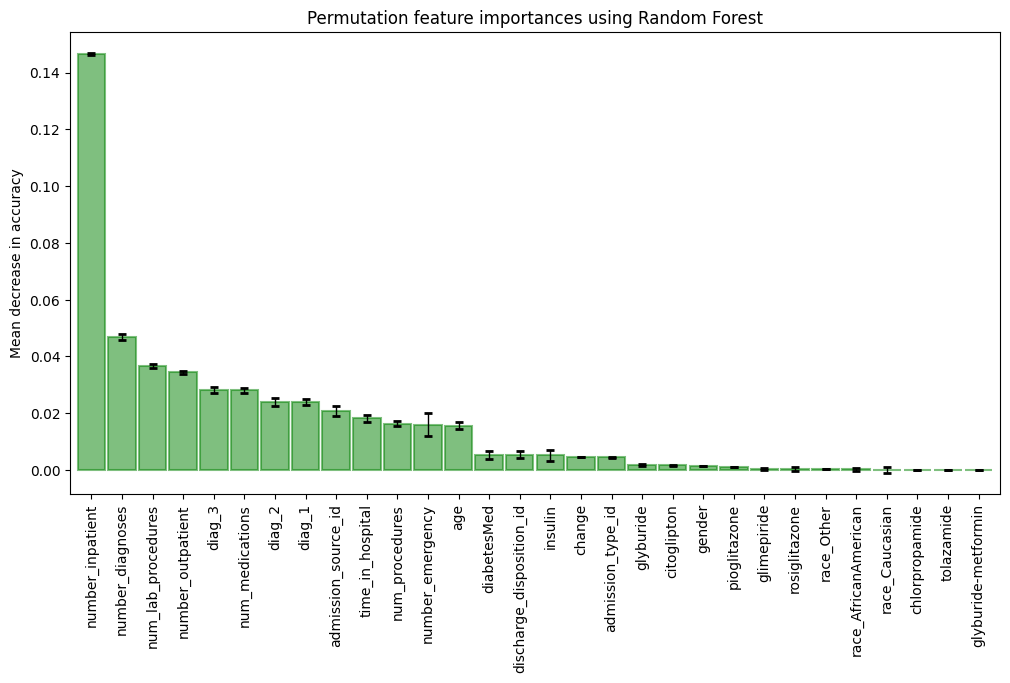

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, dFeat, dClass, n_repeats=10, random_state=random_seed, n_jobs=-1)
forest_permutations = pd.DataFrame(result.importances_mean, index=dFeat_df.columns, columns=["Permutation Importance"])
forest_permutations = forest_permutations.sort_values(by="Permutation Importance", ascending=False)

forest_permutations.plot.bar(yerr=result.importances_std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
plt.title("Permutation feature importances using Random Forest")
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in accuracy")
plt.show()

In [9]:
forest_permutations

,Permutation Importance
number_inpatient,0.146516
number_diagnoses,0.046930
num_lab_procedures,0.036738
number_outpatient,0.034401
diag_3,0.028179
num_medications,0.028034
diag_2,0.024044
diag_1,0.023961
admission_source_id,0.020757
time_in_hospital,0.018172


We can analyze the impact of deleting features starting from the least important in terms of MDA.

In [10]:
forest_permutations_asc = forest_permutations.sort_values(by="Permutation Importance", ascending=True)
accuracy_list = []

acc_full_features = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
dFeat_df1 = dFeat_df.copy()

for i in range(dFeat.shape[1]):

    column = forest_permutations_asc.index[:i]

    dFeat1 = dFeat_df1.drop(columns=column)
    dFeat1 = dFeat1.to_numpy()
    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat1, dClass):

        X_train, X_test = dFeat1[train_index], dFeat1[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy without ", column, ": ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy without  Index([], dtype='object') :  0.635740379515083
Accuracy without  Index(['glyburide-metformin'], dtype='object') :  0.6316077203428982
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide'], dtype='object') :  0.6346987663193197
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide'], dtype='object') :  0.635944424481974
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide',
       'race_Caucasian'],
      dtype='object') :  0.6330463015245623
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'race_Caucasian',
       'race_AfricanAmerican'],
      dtype='object') :  0.6307701521140257
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'race_Caucasian',
       'race_AfricanAmerican', 'race_Other'],
      dtype='object') :  0.6353228787023253
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'race_Caucasian',
       'race_Af

Text(0, 0.5, 'Accuracy')

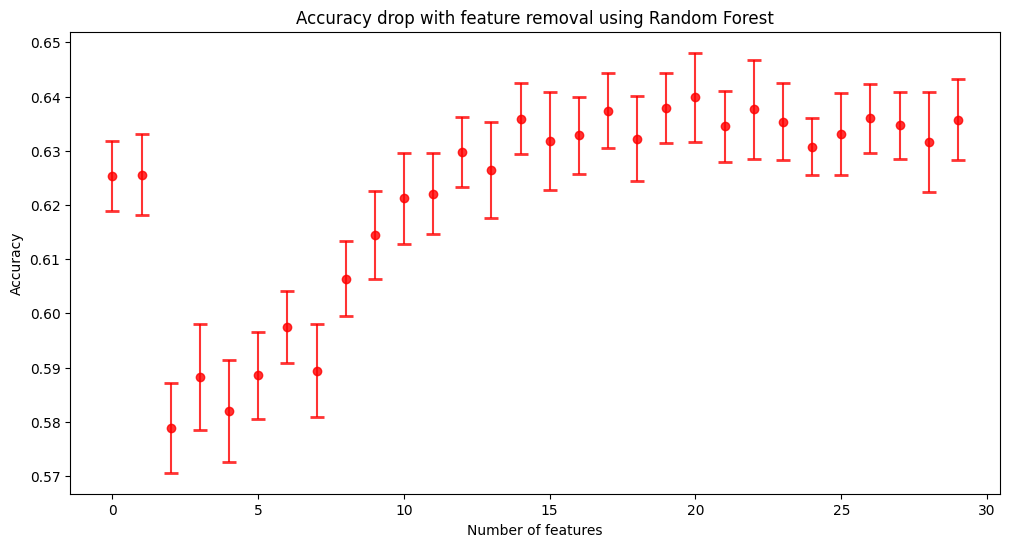

In [11]:
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(forest_permutations_asc))[::-1],accuracy_list, yerr=error_list, fmt='o', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5)
plt.title("Accuracy drop with feature removal using Random Forest")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")

In [12]:
features_str = forest_permutations_asc.index.to_list()
features_str[:10]

['glyburide-metformin',
 'chlorpropamide',
 'tolazamide',
 'race_Caucasian',
 'race_AfricanAmerican',
 'race_Other',
 'rosiglitazone',
 'glimepiride',
 'pioglitazone',
 'gender']

In [13]:
# Delete the follwoing features according to the analysis above
# dFeat_df = dFeat_df.drop(columns=["race_Other", "race_Caucasian", "race_AfricanAmerican", "glyburide-metformin", "glimepiride", "pioglitazone", "rosiglitazone", "tolazamide", "chlorpropamide", "citoglipton", "glyburide"])
dFeat_df = dFeat_df.drop(columns=features_str[:10])
dFeat = dFeat_df.to_numpy()
dFeat.shape

(4837, 20)

# Model Parameters

## Random Forest

Parameter to be considered: n_estimators (number of trees in the forest)

In [14]:
n_estimators_list = [5, 10, 25, 50, 100, 200, 300, 400, 500]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for n_estimators in n_estimators_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_estimators, " estimators: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  5  estimators:  0.58032099652653
Accuracy with  10  estimators:  0.6109131974744624
Accuracy with  25  estimators:  0.6245683828687781
Accuracy with  50  estimators:  0.6346974830176412
Accuracy with  100  estimators:  0.6361424807076981
Accuracy with  200  estimators:  0.6392480707698099
Accuracy with  300  estimators:  0.6334573858289273
Accuracy with  400  estimators:  0.634283832109919
Accuracy with  500  estimators:  0.6363520866485294


Text(0, 0.5, 'Accuracy')

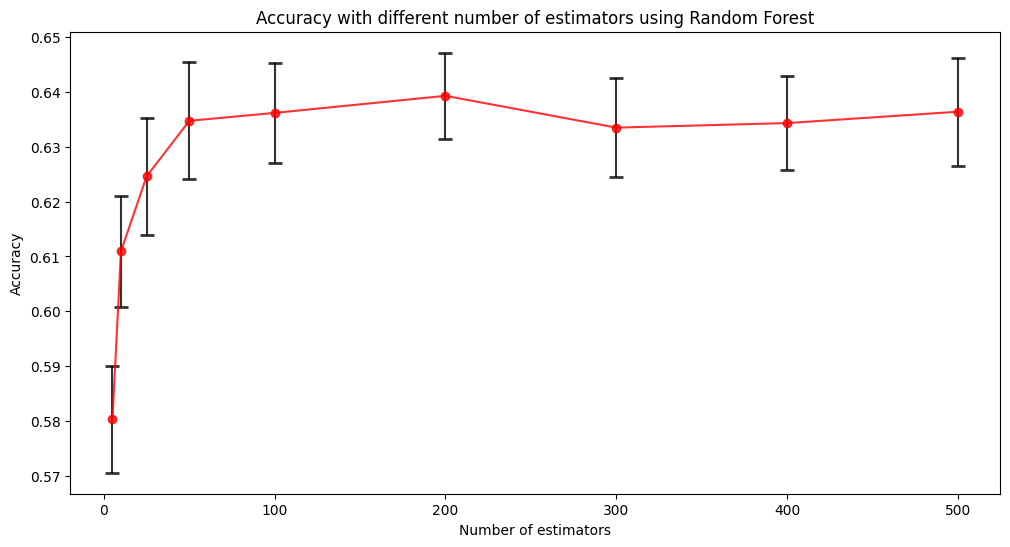

In [15]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_estimators_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different number of estimators using Random Forest")
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

The, we select n_estimators = 100.

## Decision Tree

For the DecisionTreeClassifier we study the variation of max_depth parameter (maximum depth of the tree).

In [30]:
from sklearn.tree import DecisionTreeClassifier

criterion_list = ['gini', 'entropy']
max_depth_list = [1,2,3,4,5,6,7,8,9,10,13,18,22,25,35, 50]

accuracy_array = np.zeros((len(criterion_list), len(max_depth_list)))
error_array = np.zeros((len(criterion_list), len(max_depth_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, criterion in enumerate(criterion_list):

    print("Criterion: ", criterion)

    for j, max_depth in enumerate(max_depth_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create a Random Forest Classifier
            dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_seed, criterion=criterion)

            # Fit the model on the training data
            dt.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = dt.predict(X_test)

            # Calculate performance metrics
            pm = Performance_metrics(y_test, y_pred)
            accuracy_mean.append(pm.accuracy())
        
        acc = np.mean(accuracy_mean)
        print("Accuracy with ", max_depth, " estimators: ", acc)
        accuracy_array[i][j] = acc
        error_array[i][j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Criterion:  gini
Accuracy with  1  estimators:  0.6255980185822082
Accuracy with  2  estimators:  0.6241530208921514
Accuracy with  3  estimators:  0.6266315042006741
Accuracy with  4  estimators:  0.6258054856869086
Accuracy with  5  estimators:  0.6243609157640778
Accuracy with  6  estimators:  0.6214645038755712
Accuracy with  7  estimators:  0.6239446982529986
Accuracy with  8  estimators:  0.6212501924952518
Accuracy with  9  estimators:  0.621671115445819
Accuracy with  10  estimators:  0.6096731002857485
Accuracy with  13  estimators:  0.5939599267662509
Accuracy with  18  estimators:  0.5675033793610869
Accuracy with  22  estimators:  0.5637779545882313
Accuracy with  25  estimators:  0.5660566706021252
Accuracy with  35  estimators:  0.5677069965607514
Accuracy with  50  estimators:  0.5677069965607514
Criterion:  entropy
Accuracy with  1  estimators:  0.6255980185822082
Accuracy with  2  estimators:  0.6241530208921514
Accuracy with  3  estimators:  0.6243566380918161
Accurac

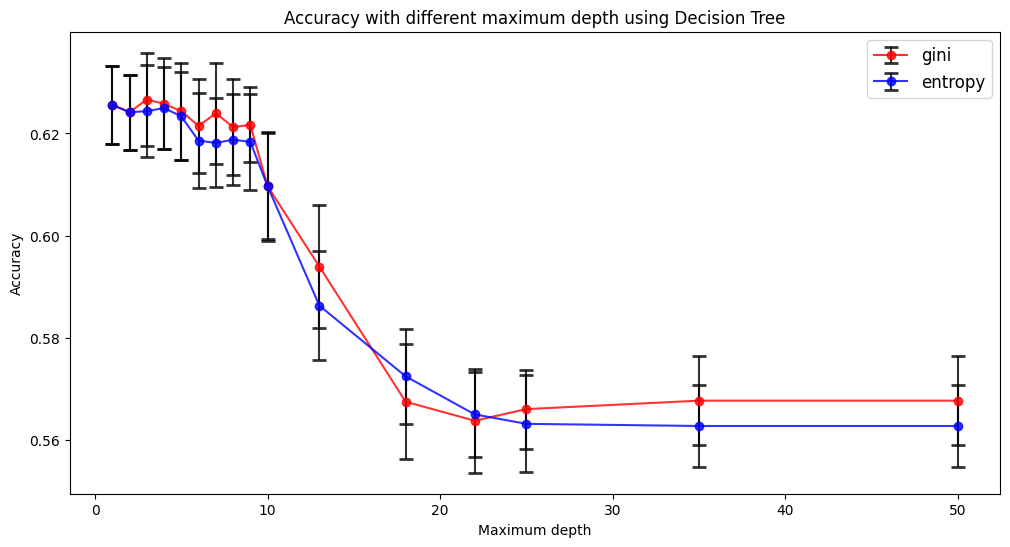

In [33]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(max_depth_list, accuracy_array[0], yerr=error_array[0], fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[0])
plt.errorbar(max_depth_list, accuracy_array[1], yerr=error_array[1], fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[1])
plt.title("Accuracy with different maximum depth using Decision Tree")
plt.xlabel("Maximum depth")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=12)

## K-nearest Neighbors

In this classifier we consider how the accuracy varies depending on the number of neighbors (n_neighbors)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_list = [5, 10, 25, 50, 75, 90, 100, 110, 125, 150, 200, 250 ,300, 400, 500]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for n_neighbors in n_neighbors_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        kn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)

        # Fit the model on the training data
        kn.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = kn.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_neighbors, " estimators: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  5  estimators:  0.5379523638416919
Accuracy with  10  estimators:  0.5532476087812057
Accuracy with  25  estimators:  0.5544731618842291
Accuracy with  50  estimators:  0.5695737727358281
Accuracy with  75  estimators:  0.5660519651626371
Accuracy with  90  estimators:  0.5757661311020994
Accuracy with  100  estimators:  0.5763833992094861
Accuracy with  110  estimators:  0.575769553239909
Accuracy with  125  estimators:  0.5722511678045274
Accuracy with  150  estimators:  0.5743177112742329
Accuracy with  200  estimators:  0.5697692623581951
Accuracy with  250  estimators:  0.5646014064986397
Accuracy with  300  estimators:  0.5637732491487432
Accuracy with  400  estimators:  0.5590237496363979
Accuracy with  500  estimators:  0.5584034871584279


Text(0, 0.5, 'Accuracy')

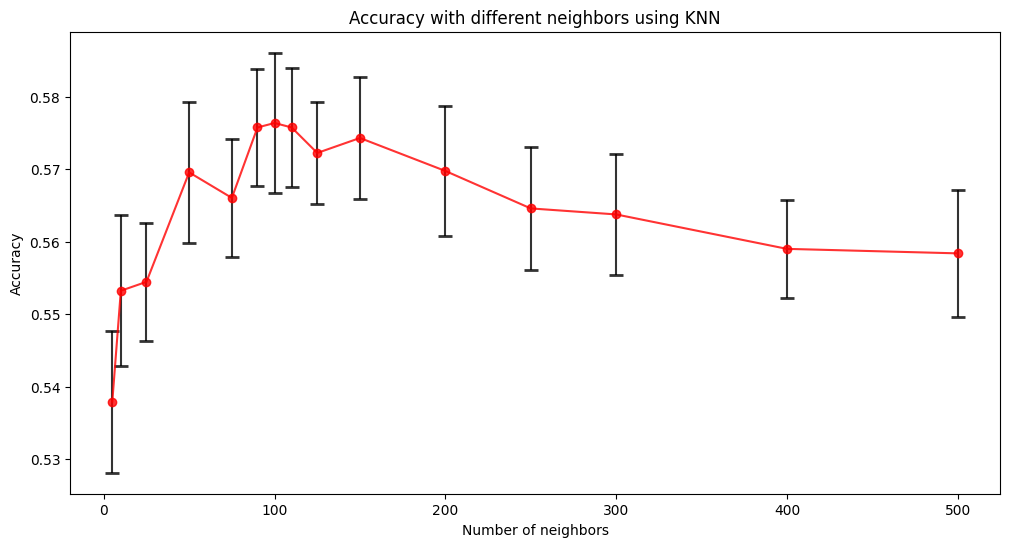

In [26]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_neighbors_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different neighbors using KNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")

## Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

No analysis performed in this model.

## Support Vector Machine

## Logistic Regression

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models_dict = {
    "RF": RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy'), # Random Forest
    "DT": DecisionTreeClassifier(random_state=random_seed, criterion='entropy', max_depth=5), # Decision Tree
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1), # K-Nearest Neighbors
    "GNB": GaussianNB(), # Gaussian Naive Bayes
    "SVC": SVC(random_state=random_seed, probability=True), # Support Vector Classifier
    "LR": LogisticRegression(random_state=random_seed, max_iter=1000), # Logistic Regression
}

In [ ]:
# # Now we compute the ROC curve and AUC for the different classifiers
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import StratifiedKFold

# kf = StratifiedKFold(n_splits=20)

# Roc_dict = {
#     "RF": [],
#     "DT": [],
#     "KNN": [],
#     "GNB": [],
#     "SVC": [],
#     "LR": []
# }

# # Compute each classification task
# for clf_name, clf in models_dict.items():

#     print(f"Classifier: {clf_name}")
    
#     # Store the ROC curve data for each fold
#     mean_fpr = np.linspace(0, 1, 100)
#     tpr_list = []

#     # Compute the ROC curve and AUC for each fold
#     for train_index, test_index in kf.split(dFeat, dClass):

#         X_train, X_test = dFeat[train_index], dFeat[test_index]
#         y_train, y_test = dClass[train_index], dClass[test_index]

#         # Create a Random Forest Classifier
#         model = clf

#         # Fit the model on the training data
#         model.fit(X_train, y_train)

#         # Make predictions on the test data
#         y_pred = model.predict(X_test)

#         # Calculate the ROC curve and AUC
#         fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
#         tpr_list.append(np.interp(mean_fpr, fpr, tpr))

#     # Calculate the mean ROC curve and AUC
#     mean_tpr = np.mean(tpr_list, axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)

#     Roc_dict[clf_name].append((mean_fpr, mean_tpr, mean_auc))

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


In [ ]:
# Now we compute the ROC curve and AUC for the different classifiers
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


Roc_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dFeat, dClass, test_size=0.2, random_state=random_seed)

# Compute each classification task
for clf_name, clf in models_dict.items():

    print(f"Classifier: {clf_name}")
    # Create a Random Forest Classifier
    model = clf

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    mean_auc = auc(fpr, tpr)

    Roc_dict[clf_name].append((fpr, tpr, auc))

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


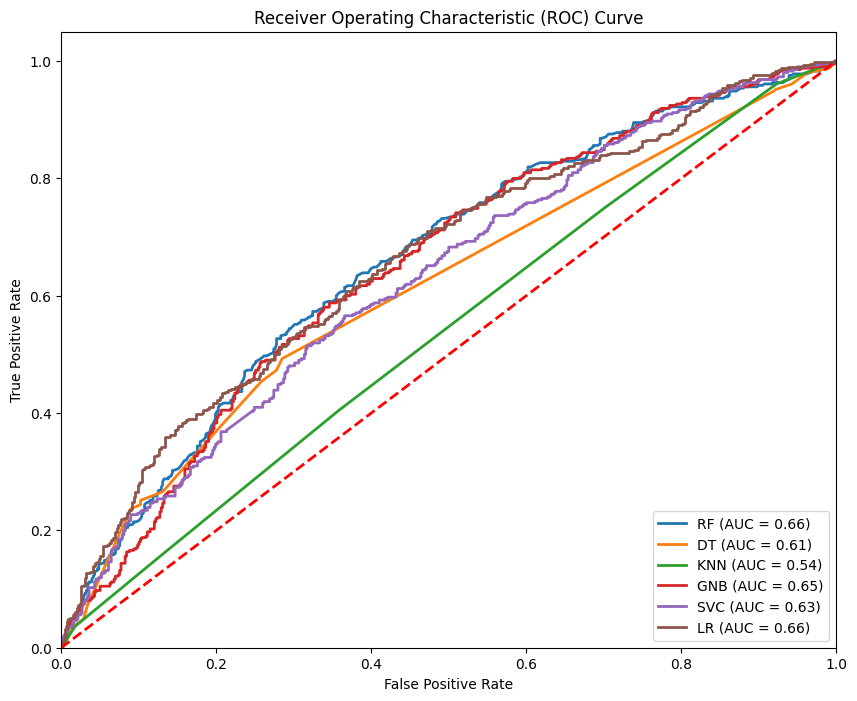

In [31]:
# Plotting the ROC curves for each classifier
plt.figure(figsize=(10, 8))

for clf_name, meas_list in Roc_dict.items():
    mean_fpr = meas_list[0][0]
    mean_tpr = meas_list[0][1]
    mean_auc = auc(mean_fpr, mean_tpr)  # Calculate the AUC value
    plt.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Model measure comparison

In this section we compare the measures and the performance metrics and cost for each classifier.

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

Performance_metrics_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

for model_name, model in models_dict.items():

    print(f"Classifier: {model_name}")

    accuracy_list = []
    precision_list = []
    recall_list = []
    f_measure_list = []
    cost_list = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_list.append(pm.accuracy())
        precision_list.append(pm.precision())
        recall_list.append(pm.recall())
        f_measure_list.append(pm.f_measure())
        cost_list.append(pm.cost())

    acc = np.mean(accuracy_list)
    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f_measure = np.mean(f_measure_list)
    cost = np.mean(cost_list)

    # Store the performance metrics in the dictionary
    Performance_metrics_dict[model_name].append((acc, precision, recall, f_measure, cost))

# Create a DataFrame to store the performance metrics
performance_df = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])

for model_name, metrics in Performance_metrics_dict.items():
    acc, precision, recall, f_measure, cost = metrics[0]
    performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)

performance_df = performance_df.set_index("Classifier")
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)
performance_df

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


C:\Users\mate1\AppData\Local\Temp\ipykernel_16012\3961184593.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)


,Accuracy,Precision,Recall,F-measure,Cost
Classifier,,,,,
RF,0.639255,0.478545,0.623924,0.540975,628.7
LR,0.629325,0.370842,0.648466,0.470126,490.3
DT,0.625811,0.451439,0.609303,0.514829,648.1
GNB,0.615061,0.262849,0.677377,0.377357,374.5
SVC,0.608025,0.292530,0.632743,0.398100,458.9
KNN,0.531733,0.414600,0.470869,0.440410,1041.5


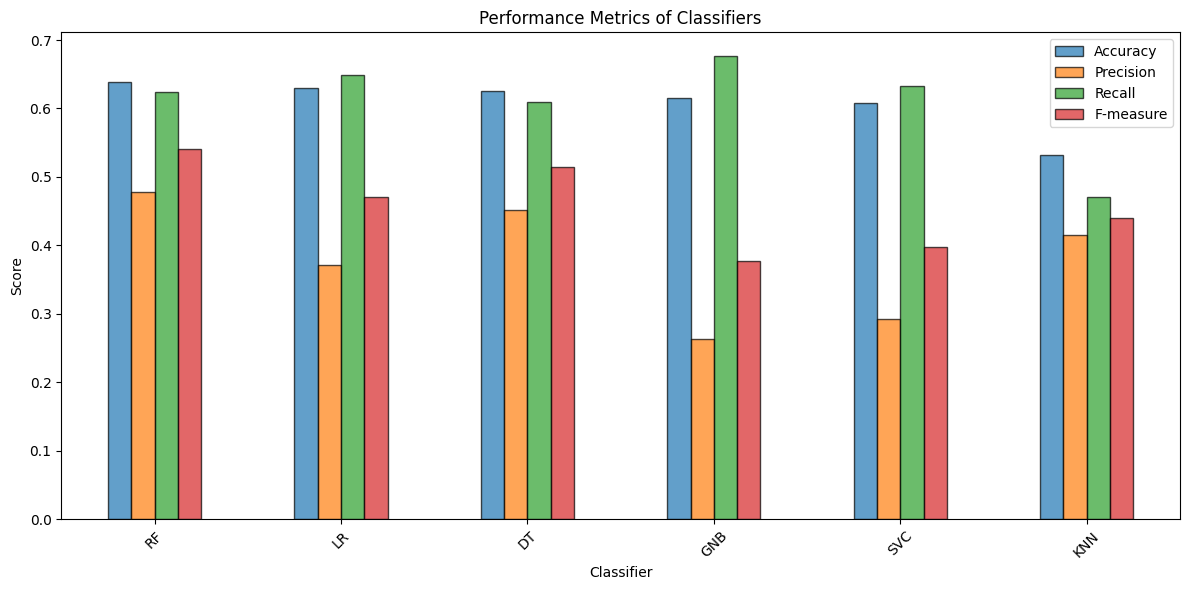

In [78]:
# Plot bar chart of performance metrics
no_cost_df = performance_df.drop(columns=["Cost"])

no_cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

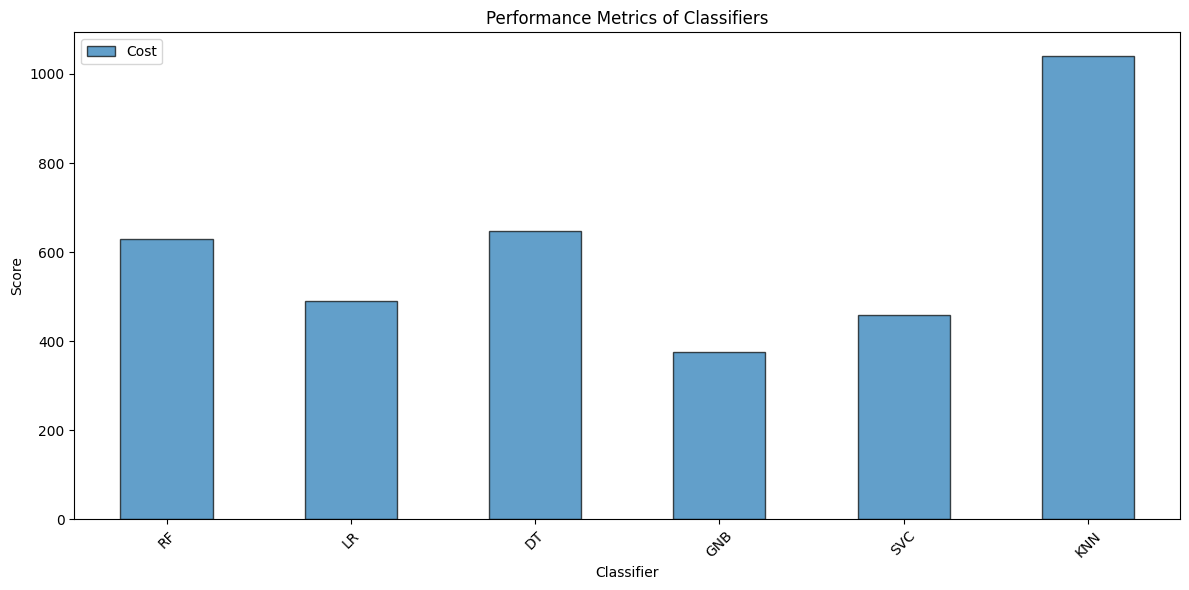

In [79]:
cost_df = performance_df.drop(columns=["Accuracy", "Precision", "Recall", "F-measure"])

cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()